# Repeat Measurement Correlation

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.stats.stats import pearsonr, spearmanr

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#Custom functions for common DataFrame operations

def drop_none_na(input_df):
    # Function that replaces 'None's with 'NaN's and then drops all 'NaN's in a DataFrame.

    output_df = input_df.replace('None', 'NaN').dropna().copy() #I don't think the replace works

    return output_df


def drop_inf(input_df):
    # Function that changes contents to float and removes 'inf' values
    # Requires numpy imported as np
    
    output_df = input_df.astype(float)
    output_df = output_df.replace([np.inf, -np.inf], np.nan).dropna()

    return output_df


def selectColumns_dropNans(input_df, column_name_list, dropInfs = False):
    # Function that takes only the columns named in inputed list and then drops all 'None' and 'NaN' values 
    
    internal_df = input_df[column_name_list].copy() #Take subset of phenotypes/columns
    internal_df = drop_none_na(internal_df)
    if dropInfs:
        internal_df = drop_inf(internal_df)
    
    return internal_df


def percent_to_decimal(input_df):
    # Function that takes DataFrame with percent values and changes them to decimal values
    output_df = input_df.copy()
    for name in output_df.columns.tolist():
        output_df[name] = output_df[name].str.rstrip('%').astype('float') / 100.0

    return output_df

In [3]:
#Paths to files where the data is
path_to_excel = '/home/antton/TFM/aitzkoa_SNP_association_data/Copy of CB data 1-857_H.xlsx'
path_to_SNPtable = '/home/antton/TFM/aitzkoa_SNP_association_data/snp_list.xlsx'

# DATA EXTRACTION
### Manual Gating - Data Extraction
Extract results from manual gating from the excel file. Select only those phenotypes of interest and put the data into a DataFrame named 'nat_selected_pheno_all_df'.

In [4]:
# Get list of samples that have been gated incorrectly

with open('/home/antton/TFM/samples_to_remove_mar24.txt', 'r') as f:
    #Text file contaning names of samples to remove
    samples_to_remove = []
    for line in f:
        samples_to_remove.append(line.rstrip().split('-')[1]+'.fcs')

In [5]:
#Store phenotype data in DataFrame!!

nat_excel_df = pd.read_excel(path_to_excel, na_values='None') #Load file
nat_excel_df.drop([0, 1], axis=0, inplace=True)  #Drop first two rows, which contain tags
nat_excel_df.columns = ['filenames'] + nat_excel_df.columns.tolist()[1:] #Rename the first column to 'filenames'
nat_excel_df = nat_excel_df[~nat_excel_df.filenames.isin(samples_to_remove)] #Remove incorrect samples
nat_excel_df

,filenames,Viable | Freq. of Parent,Viable/Single Cells | Count,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+ | Freq. of Parent,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38- | Freq. of Parent,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/HSC | Freq. of Parent,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MPP | Freq. of Parent,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MLP | Freq. of Parent,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MLP/CD10+MLP | Freq. of Parent,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/HSC | Freq. of null,...,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/GMP | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/CMP | Freq. of null,Viable/Single Cells/G1/CD45+34+ | Freq. of Parent,Viable/Single Cells/G1/CD45+34- | Freq. of Parent,Unnamed: 23,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+ | Freq. of Parent.1,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/Lin-45+34- | Freq. of Parent,Unnamed: 26,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/HSC | Freq. of CD45+,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+ | Freq. of CD45+
2,A1 1.fcs,93.3 %,985000,28.9 %,25.8 %,27.8 %,62.4 %,7.24 %,75.4 %,7.17 %,...,7.27 %,24.9 %,1.78 %,88.3 %,1.97602,29.0 %,60.8 %,32.294,0.14 %,1.89 %
3,A2 2.fcs,88.2 %,979000,19.3 %,30.5 %,28.6 %,62.5 %,9.43 %,75.1 %,8.74 %,...,10.4 %,31.3 %,0.69 %,71.3 %,0.958466,19.3 %,71.4 %,21.2789,0.082 %,0.94 %
4,A3 3.fcs,94.7 %,1020000,36.6 %,33.6 %,19.4 %,58.6 %,19.5 %,82.1 %,6.52 %,...,7.09 %,21.9 %,2.06 %,88.8 %,2.26722,36.6 %,52.8 %,40.9396,0.14 %,2.21 %
5,A4 4.fcs,92.7 %,2290000,22.3 %,23.0 %,15.0 %,63.0 %,20.2 %,71.2 %,3.45 %,...,7.82 %,33.1 %,1.28 %,90.8 %,1.3901,22.3 %,58.8 %,27.4969,0.046 %,1.35 %
6,A5 5.fcs,84.9 %,2590000,34.3 %,25.6 %,18.8 %,66.0 %,13.6 %,62.5 %,4.82 %,...,10.5 %,19.3 %,2.73 %,81.3 %,3.24884,34.3 %,47.7 %,41.8293,0.15 %,3.05 %
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,E5 845.fcs,87.9 %,661000,15.3 %,23.7 %,17.1 %,57.4 %,25.6 %,63.7 %,4.04 %,...,11.5 %,49.5 %,0.60 %,75.5 %,0.788436,15.3 %,72.0 %,17.5258,0.033 %,0.83 %
789,E6 846.fcs,88.4 %,821000,17.3 %,20.6 %,10.0 %,71.8 %,16.2 %,78.7 %,2.07 %,...,10.9 %,48.0 %,0.55 %,63.4 %,0.860047,17.3 %,65.2 %,20.9697,0.018 %,0.88 %
790,E7 847.fcs,88.5 %,962000,19.2 %,27.1 %,34.2 %,55.8 %,8.83 %,68.6 %,9.26 %,...,6.63 %,42.5 %,0.75 %,74.4 %,0.998004,19.2 %,64.1 %,23.0492,0.094 %,1.01 %
791,E8 848.fcs,93.5 %,731000,11.2 %,20.1 %,26.0 %,67.9 %,6.73 %,50.0 %,5.22 %,...,4.39 %,40.7 %,0.59 %,28.8 %,2.00749,11.2 %,45.2 %,19.8582,0.065 %,1.24 %


In [6]:
#Phenotypes of interest in Natsumi's DataFrame to keep
nat_selected_phenotype_list = [
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/HSC | Freq. of null',
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MPP | Freq. of null',
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MLP | Freq. of null',
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/B-NK | Freq. of null',
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/MEP | Freq. of null',
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/CMP | Freq. of null',
    'Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/GMP | Freq. of null']


In [7]:
#Convert filenames into CBX format IDs
renamed_IDs = list()
for name in nat_excel_df['filenames'].tolist():
    if type(name) != float:
        renamed_IDs.append('CB'+name.split(' ')[1][:-4])
    else:
        renamed_IDs.append(name)

#Replace filename column with sample name (CBXX)
nat_excel_df["filenames"]=renamed_IDs 

#Change axis to sample name
nat_excel_df.set_axis(nat_excel_df["filenames"].tolist(),axis='rows',inplace=True)

#Make sub-DataFrame containing only phenotypes of interest
nat_selected_pheno_all_df = selectColumns_dropNans(nat_excel_df, nat_selected_phenotype_list)

#Dealing with duplicates
#The current approach is to just drop the duplicates. The ideal approach would be to calculate the mean.
nat_selected_pheno_all_df = nat_selected_pheno_all_df[~nat_selected_pheno_all_df.index.duplicated(keep='last')].copy()

nat_selected_pheno_all_df

,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/HSC | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MPP | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38-/MLP | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/B-NK | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/MEP | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/CMP | Freq. of null,Viable/Single Cells/G1/CD45+/CD3-/CD14-CD19-/CD16-CD56-/CD34+/CD38+/CD10-/GMP | Freq. of null
CB1,7.17 %,16.1 %,1.87 %,1.20 %,12.2 %,24.9 %,7.27 %
CB2,8.74 %,19.1 %,2.88 %,1.74 %,4.42 %,31.3 %,10.4 %
CB3,6.52 %,19.7 %,6.54 %,1.47 %,3.00 %,21.9 %,7.09 %
CB4,3.45 %,14.5 %,4.65 %,1.16 %,6.32 %,33.1 %,7.82 %
CB5,4.82 %,16.9 %,3.49 %,2.16 %,3.02 %,19.3 %,10.5 %
...,...,...,...,...,...,...,...
CB844,8.83 %,20.8 %,7.04 %,3.07 %,5.52 %,39.9 %,11.3 %
CB845,4.04 %,13.6 %,6.08 %,2.61 %,14.0 %,49.5 %,11.5 %
CB846,2.07 %,14.8 %,3.34 %,5.05 %,14.5 %,48.0 %,10.9 %
CB847,9.26 %,15.1 %,2.39 %,2.31 %,19.1 %,42.5 %,6.63 %


In [8]:
# Change from percent to decimal
nat_selected_pheno_all_df = percent_to_decimal(nat_selected_pheno_all_df)

# Rename columns to simplified pyhenotype names
for name in nat_selected_pheno_all_df.columns.tolist():
    
    short_name = name.split('/')[-1].split('|')[0][:-1]+'/CD34+'
    nat_selected_pheno_all_df[short_name] = nat_selected_pheno_all_df[name]
    nat_selected_pheno_all_df = nat_selected_pheno_all_df.drop(name, axis=1)


In [9]:
#Final DF with the manual gating values for the most relevant phenotypes
nat_selected_pheno_all_df

,HSC/CD34+,MPP/CD34+,MLP/CD34+,B-NK/CD34+,MEP/CD34+,CMP/CD34+,GMP/CD34+
CB1,0.0717,0.161,0.0187,0.0120,0.1220,0.249,0.0727
CB2,0.0874,0.191,0.0288,0.0174,0.0442,0.313,0.1040
CB3,0.0652,0.197,0.0654,0.0147,0.0300,0.219,0.0709
CB4,0.0345,0.145,0.0465,0.0116,0.0632,0.331,0.0782
CB5,0.0482,0.169,0.0349,0.0216,0.0302,0.193,0.1050
...,...,...,...,...,...,...,...
CB844,0.0883,0.208,0.0704,0.0307,0.0552,0.399,0.1130
CB845,0.0404,0.136,0.0608,0.0261,0.1400,0.495,0.1150
CB846,0.0207,0.148,0.0334,0.0505,0.1450,0.480,0.1090
CB847,0.0926,0.151,0.0239,0.0231,0.1910,0.425,0.0663


### My own gating data
Extract results from AliGater gating and put them into a DataFrame named 'my_selected_pheno_all_df'.

Note that the phenotypes that are comparable with the manual gating are those calculated out of Linage Negative CD34+ cells.


In [10]:
#Path to where the data is
my_phenos_filepath = '/home/antton/TFM/output/aligater_output_test/cblood_test_2021-03-23.txt'
my_pheno_df = pd.read_table(my_phenos_filepath, na_values='None')

In [11]:
my_selected_phenotype_list = [  # Relevant phenos out of CD34+
 'HSC_1/CD34+',
 'MPP_1/CD34+',
 'MLP_1/CD34+',
 'B-NK_2/CD34+',
 'MEP_1/CD34+',
 'CMP_1/CD34+',
 'GMP_1/CD34+']

my_selected_phenotype_list_2 = [  # Relevant phenos out of Lin-CD34+
 'HSC_2/Lin-CD34+',
 'MPP_2/Lin-CD34+',
 'MLP_2/Lin-CD34+',
 'B-NK_3/Lin-CD34+',
 'MEP_2/Lin-CD34+',
 'CMP_2/Lin-CD34+',
 'GMP_2/Lin-CD34+']

my_selected_phenotype_list_3 = [  # Relevant phenos for repeat-sample correlation
    'CD34+',
    'CD34+/CD45+',
    'linneg_cd34pos/CD45+',
    'HSC_1',
    'HSC_2/Lin-CD34+']
    

In [12]:
#Create and add a 'CBID' column to the DataFrame, then rename the indeces using that column.
CBID_col_middle_step = my_pheno_df['sampleName'].tolist()
CBID_col = ['CB'+x.split()[-1].split('-')[0] for x in CBID_col_middle_step]
my_pheno_df.insert(0,'CBID',CBID_col)

#Change axis to CBID
my_pheno_df.set_axis(my_pheno_df['CBID'].tolist(),axis='rows')

#Make sub-DataFrame containing only phenotypes of interest, no NaNs, no Infs
my_selected_pheno_all_df = selectColumns_dropNans(my_pheno_df, my_selected_phenotype_list_2, dropInfs = True)

#Dealing with duplicates
#The current approach is to just drop the duplicates. The ideal approach would be to calculate the mean.
my_selected_pheno_all_df = my_selected_pheno_all_df[~my_selected_pheno_all_df.index.duplicated(keep='last')].copy()

#Final DF with the AliGater gating values for the most relevant phenotypes
my_selected_pheno_all_df

/home/antton/anaconda3/envs/python27env/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  import sys


,HSC_2/Lin-CD34+,MPP_2/Lin-CD34+,MLP_2/Lin-CD34+,B-NK_3/Lin-CD34+,MEP_2/Lin-CD34+,CMP_2/Lin-CD34+,GMP_2/Lin-CD34+
CB31,0.075402,0.170581,0.061893,0.017129,0.096150,0.295338,0.246777
CB32,0.083809,0.181772,0.035336,0.019450,0.124440,0.417923,0.114664
CB33,0.060669,0.117890,0.105826,0.068942,0.099966,0.360221,0.142709
CB35,0.043884,0.060691,0.019141,0.021942,0.183940,0.443978,0.186275
CB37,0.083937,0.154614,0.057143,0.038961,0.105400,0.315789,0.212577
...,...,...,...,...,...,...,...
CB1967,0.054602,0.189006,0.048407,0.047672,0.096288,0.384995,0.149892
CB1971,0.054599,0.198345,0.044088,0.021217,0.107640,0.324964,0.214696
CB1893,0.051781,0.197676,0.039214,0.039592,0.100444,0.372862,0.168100
CB1952,0.058929,0.151597,0.076248,0.034638,0.094692,0.426451,0.120558


### Selection of common samples in both Manual and AliGater
Only a subset of the available samples has been manually gated. We will use those samples only.  

In [13]:
#Take only samples that exist in both maual gating and AliGater gating
common_samples_list = list(set(nat_selected_pheno_all_df.index.tolist()).intersection(my_selected_pheno_all_df.index.tolist()))

sorted_common_samples_list = sorted(common_samples_list, key = lambda name: int(name[2:]))

my_selected_pheno_df = my_selected_pheno_all_df.loc[sorted_common_samples_list].copy()
nat_selected_pheno_df = nat_selected_pheno_all_df.loc[sorted_common_samples_list].copy()


In [14]:
nat_selected_pheno_df.reset_index(drop=False, inplace=True)
nat_selected_pheno_df = nat_selected_pheno_df.assign(Method='Manual')
nat_selected_pheno_df

,index,HSC/CD34+,MPP/CD34+,MLP/CD34+,B-NK/CD34+,MEP/CD34+,CMP/CD34+,GMP/CD34+,Method
0,CB27,0.0502,0.2670,0.0158,0.0195,0.1030,0.464,0.0637,Manual
1,CB28,0.0597,0.1230,0.0456,0.0830,0.0659,0.508,0.0815,Manual
2,CB29,0.0330,0.1240,0.0327,0.0408,0.0482,0.552,0.1600,Manual
3,CB30,0.0294,0.1280,0.0845,0.0417,0.0778,0.501,0.1210,Manual
4,CB31,0.0319,0.0873,0.0242,0.0162,0.0977,0.475,0.2230,Manual
...,...,...,...,...,...,...,...,...,...
692,CB843,0.0339,0.1420,0.1050,0.0395,0.0809,0.521,0.0819,Manual
693,CB844,0.0883,0.2080,0.0704,0.0307,0.0552,0.399,0.1130,Manual
694,CB845,0.0404,0.1360,0.0608,0.0261,0.1400,0.495,0.1150,Manual
695,CB846,0.0207,0.1480,0.0334,0.0505,0.1450,0.480,0.1090,Manual


In [15]:
#Rename columns in 'my_selected_pheno_df' from '/Lin-CD34+' to just 'CD34+' so that they are comparable to Natsumi's
for column in my_selected_pheno_df.columns.tolist():
    new_name = column.split('_')[0]+'/CD34+'  #Take first part of the name till '_', then add '/CD34+'
    my_selected_pheno_df[new_name] = my_selected_pheno_df[column]
    my_selected_pheno_df = my_selected_pheno_df.drop(column, axis=1)
    

In [16]:
my_selected_pheno_df.reset_index(drop=False, inplace=True)
my_selected_pheno_df = my_selected_pheno_df.assign(Method='AliGater')
my_selected_pheno_df

,index,HSC/CD34+,MPP/CD34+,MLP/CD34+,B-NK/CD34+,MEP/CD34+,CMP/CD34+,GMP/CD34+,Method
0,CB27,0.079002,0.188812,0.025129,0.025301,0.123924,0.407229,0.114114,AliGater
1,CB28,0.082511,0.133578,0.061395,0.071838,0.090085,0.379160,0.128873,AliGater
2,CB29,0.092660,0.136167,0.058452,0.030223,0.115244,0.352375,0.176685,AliGater
3,CB30,0.086142,0.102622,0.082022,0.029963,0.085393,0.429963,0.152060,AliGater
4,CB31,0.075402,0.170581,0.061893,0.017129,0.096150,0.295338,0.246777,AliGater
...,...,...,...,...,...,...,...,...,...
692,CB843,0.070265,0.081763,0.103162,0.051421,0.056212,0.430214,0.140211,AliGater
693,CB844,0.055803,0.160375,0.071981,0.043611,0.092849,0.348183,0.189918,AliGater
694,CB845,0.074468,0.133985,0.068430,0.029902,0.087119,0.396780,0.182576,AliGater
695,CB846,0.090762,0.148028,0.041329,0.068341,0.089951,0.352242,0.146407,AliGater


## Comparison of general distribution and median
Let's see how the results for manual gating and AliGator-based gating compare to one another!

In [17]:
nat_selected_pheno_df
my_selected_pheno_df

,index,HSC/CD34+,MPP/CD34+,MLP/CD34+,B-NK/CD34+,MEP/CD34+,CMP/CD34+,GMP/CD34+,Method
0,CB27,0.079002,0.188812,0.025129,0.025301,0.123924,0.407229,0.114114,AliGater
1,CB28,0.082511,0.133578,0.061395,0.071838,0.090085,0.379160,0.128873,AliGater
2,CB29,0.092660,0.136167,0.058452,0.030223,0.115244,0.352375,0.176685,AliGater
3,CB30,0.086142,0.102622,0.082022,0.029963,0.085393,0.429963,0.152060,AliGater
4,CB31,0.075402,0.170581,0.061893,0.017129,0.096150,0.295338,0.246777,AliGater
...,...,...,...,...,...,...,...,...,...
692,CB843,0.070265,0.081763,0.103162,0.051421,0.056212,0.430214,0.140211,AliGater
693,CB844,0.055803,0.160375,0.071981,0.043611,0.092849,0.348183,0.189918,AliGater
694,CB845,0.074468,0.133985,0.068430,0.029902,0.087119,0.396780,0.182576,AliGater
695,CB846,0.090762,0.148028,0.041329,0.068341,0.089951,0.352242,0.146407,AliGater


In [18]:
cdf = pd.concat([nat_selected_pheno_df, my_selected_pheno_df], axis=0)


In [19]:
cdf

,index,HSC/CD34+,MPP/CD34+,MLP/CD34+,B-NK/CD34+,MEP/CD34+,CMP/CD34+,GMP/CD34+,Method
0,CB27,0.050200,0.267000,0.015800,0.019500,0.103000,0.464000,0.063700,Manual
1,CB28,0.059700,0.123000,0.045600,0.083000,0.065900,0.508000,0.081500,Manual
2,CB29,0.033000,0.124000,0.032700,0.040800,0.048200,0.552000,0.160000,Manual
3,CB30,0.029400,0.128000,0.084500,0.041700,0.077800,0.501000,0.121000,Manual
4,CB31,0.031900,0.087300,0.024200,0.016200,0.097700,0.475000,0.223000,Manual
...,...,...,...,...,...,...,...,...,...
692,CB843,0.070265,0.081763,0.103162,0.051421,0.056212,0.430214,0.140211,AliGater
693,CB844,0.055803,0.160375,0.071981,0.043611,0.092849,0.348183,0.189918,AliGater
694,CB845,0.074468,0.133985,0.068430,0.029902,0.087119,0.396780,0.182576,AliGater
695,CB846,0.090762,0.148028,0.041329,0.068341,0.089951,0.352242,0.146407,AliGater


In [20]:
mdf = pd.melt(cdf, id_vars=['index','Method'], var_name='Phenotype')

In [21]:
mdf

,index,Method,Phenotype,value
0,CB27,Manual,HSC/CD34+,0.050200
1,CB28,Manual,HSC/CD34+,0.059700
2,CB29,Manual,HSC/CD34+,0.033000
3,CB30,Manual,HSC/CD34+,0.029400
4,CB31,Manual,HSC/CD34+,0.031900
...,...,...,...,...
9753,CB843,AliGater,GMP/CD34+,0.140211
9754,CB844,AliGater,GMP/CD34+,0.189918
9755,CB845,AliGater,GMP/CD34+,0.182576
9756,CB846,AliGater,GMP/CD34+,0.146407


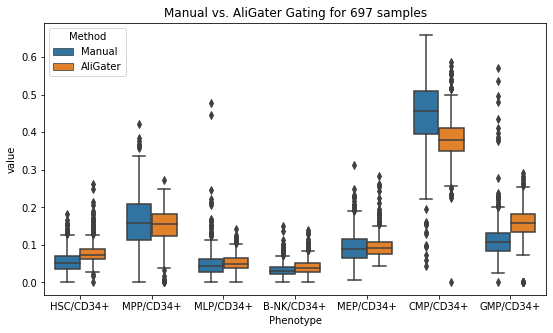

In [25]:
plt.figure(figsize=[9,5])
ax = sns.boxplot(x='Phenotype', y='value', hue='Method', data=mdf, width=0.7)
ax.set_title('Manual vs. AliGater Gating for {} samples'.format(len(sorted_common_samples_list)))

#ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()
ax.get_figure().savefig('/home/antton/TFM_final_submission/figures/gating_comparison_boxplot')

Overall we can see that de distributions are quite similar!

## Phenotype-vector correlation (aka, comparison between columns)
See how manual and AliGater results compare by calculating the correlation between the columns for the same phenotype. SPOILER: It's not very good.

In [26]:
nat_selected_pheno_df  # 'my_selected_pheno_df' is identical in shape

,index,HSC/CD34+,MPP/CD34+,MLP/CD34+,B-NK/CD34+,MEP/CD34+,CMP/CD34+,GMP/CD34+,Method
0,CB27,0.0502,0.2670,0.0158,0.0195,0.1030,0.464,0.0637,Manual
1,CB28,0.0597,0.1230,0.0456,0.0830,0.0659,0.508,0.0815,Manual
2,CB29,0.0330,0.1240,0.0327,0.0408,0.0482,0.552,0.1600,Manual
3,CB30,0.0294,0.1280,0.0845,0.0417,0.0778,0.501,0.1210,Manual
4,CB31,0.0319,0.0873,0.0242,0.0162,0.0977,0.475,0.2230,Manual
...,...,...,...,...,...,...,...,...,...
692,CB843,0.0339,0.1420,0.1050,0.0395,0.0809,0.521,0.0819,Manual
693,CB844,0.0883,0.2080,0.0704,0.0307,0.0552,0.399,0.1130,Manual
694,CB845,0.0404,0.1360,0.0608,0.0261,0.1400,0.495,0.1150,Manual
695,CB846,0.0207,0.1480,0.0334,0.0505,0.1450,0.480,0.1090,Manual


In [27]:
def plot_comparison_scatterplot(phenotype_name):
    #Function that will plot a scatterplot for each column of the dataframes. Also includes diagonal line.
    x = nat_selected_pheno_df[phenotype_name]
    y = my_selected_pheno_df[phenotype_name]
    plt.scatter(x,y)
    
    plt.plot( [0,max(x)],[0,max(y)], color='k')

    plt.title(phenotype_name)
    plt.xlabel('Manual gating values')
    plt.ylabel('AliGater values')
    plt.show()

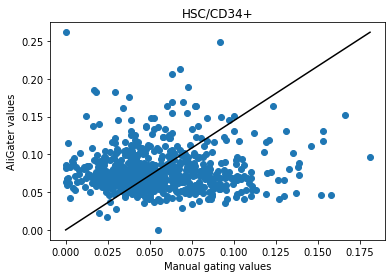

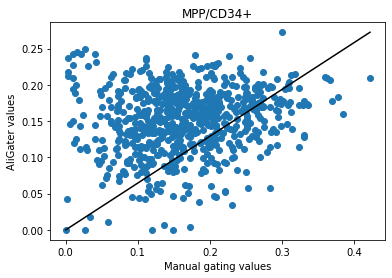

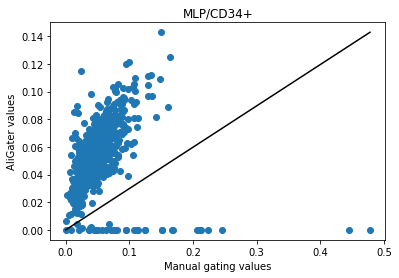

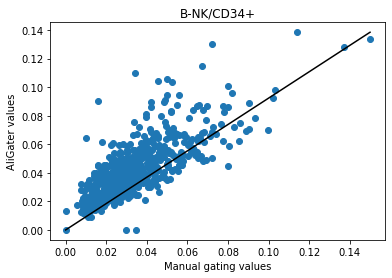

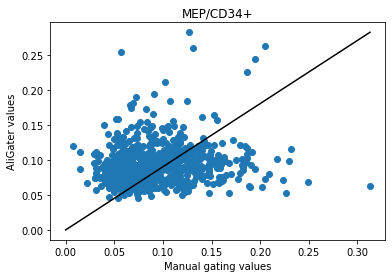

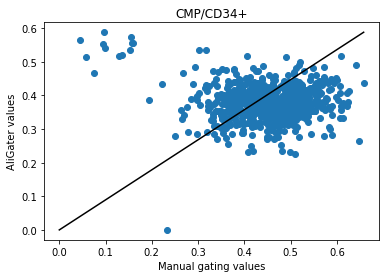

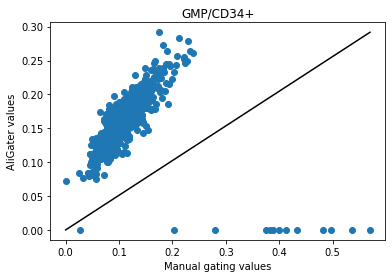

In [28]:
for pheno in nat_selected_pheno_df.columns.tolist()[1:-1]:
    
    plot_comparison_scatterplot(pheno)


In [29]:
#Calculate Person's correlation for each phenotype
pheno_pearson_correlations_list = []
#pheno_spearman_correlations_list = []
for phenotype in my_selected_pheno_df.columns.tolist()[1:-1]:
    my_col = my_selected_pheno_df[phenotype]
    nat_col = nat_selected_pheno_df[phenotype]
    pheno_pearson_correlations_list.append(pearsonr(nat_col,my_col))
    print('For '+phenotype+' Pearson correlation is '+str(pearsonr(nat_col,my_col)))

For HSC/CD34+ Pearson correlation is (0.030330077679352214, 0.4240099743258201)
For MPP/CD34+ Pearson correlation is (0.16110181993350528, 1.9241030670339672e-05)
For MLP/CD34+ Pearson correlation is (0.19951072619305357, 1.0886580253645766e-07)
For B-NK/CD34+ Pearson correlation is (0.7639701661736272, 2.2854622416798847e-134)
For MEP/CD34+ Pearson correlation is (0.11459792216007758, 0.0024453003752709646)
For CMP/CD34+ Pearson correlation is (-0.10993148518380266, 0.003662256324872012)
For GMP/CD34+ Pearson correlation is (0.12406418432241688, 0.0010300123592477742)


Results are not very good :/
Am I comparing the correct populations?? Is '/Freq. of Null' not the same as '/Lin-CD34+' ??
Will look into this further if I get the chance.

## Population-population correlation

In [36]:
my_selected_pheno_df.set_axis(my_selected_pheno_df["index"].tolist(),axis='rows',inplace=True)
nat_selected_pheno_df.set_axis(my_selected_pheno_df["index"].tolist(),axis='rows',inplace=True)


Median R-square for pop-pop correlation is:  0.8954613464932806


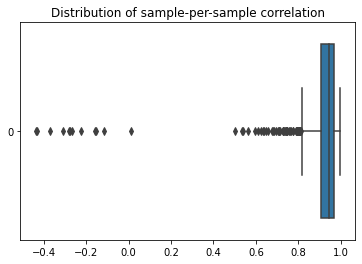

In [32]:
#Fill up list with pearsonR of each phenotype between Natsumi and me
pop_correlations_list = []
for indiv_sample in my_selected_pheno_df.index.tolist():  # Iterate sample by sample 
    my_col = my_selected_pheno_df.loc[indiv_sample]
    nat_col = nat_selected_pheno_df.loc[indiv_sample]
    pop_correlations_list.append(pearsonr(nat_col[1:-1],my_col[1:-1]))
    
    
#Separate the tuple into two lists, calculate median r_square
pop_rvalue_tuple, pop_pvalue_tuple = zip(*pop_correlations_list)
pop_rvalue_list = list(pop_rvalue_tuple)
pop_pvalue_list = list(pop_pvalue_tuple)

ax = sns.boxplot(data=[x[0] for x in pop_correlations_list], orient="h")
ax.set_title('Distribution of sample-per-sample correlation')

print('Median R-square for pop-pop correlation is: ', np.nanmedian(pop_rvalue_list)**2)

## Repeat donor correlation
In order to ensure the robustness of AliGater, we compared AliGater gating and manual gating. Of the automatically gated samples, 697 cord blood samples had also been manually gated beforehand, and of these, 56 samples had been analyzed by FCM in two separate occasions. This produced two separate Flow Cytometry Standard (FCS) files for each of the samples, which could be used to compare the consistency of both gating methods.


In [51]:
my_pheno_df

,CBID,sampleName,PBMC,PBMC/total,CD34+,CD34+/CD45+,CD3+,CD3+/CD45+,CD4+_1,CD4+_1/CD3+,...,CMP_2/Lin-CD34+,MEP_1,MEP_1/CD34+,MEP_2,MEP_2/Lin-CD34+,GMP_1,GMP_1/CD34+,GMP_2,GMP_2/Lin-CD34+,Unnamed: 67
CB27,CB27,fcs/181029 CB 60min/A1 27,330981.0,0.730082,4820.0,0.019324,169542.0,0.679731,101781.0,0.600329,...,0.410263,455.0,0.094398,455.0,0.113892,435.0,0.090249,435.0,0.108886,NaN
CB28,CB28,fcs/181029 CB 60min/A2 28,324988.0,0.623536,7762.0,0.034297,108781.0,0.480658,73911.0,0.679448,...,0.367021,611.0,0.078717,611.0,0.095588,779.0,0.100361,779.0,0.121871,NaN
CB29,CB29,fcs/181029 CB 60min/A3 29,397389.0,0.677119,4293.0,0.013049,140557.0,0.427233,82923.0,0.589960,...,0.338363,348.0,0.081062,348.0,0.097234,719.0,0.167482,719.0,0.200894,NaN
CB30,CB30,fcs/181029 CB 60min/A4 30,1190625.0,0.688036,3962.0,0.003569,441164.0,0.397383,298434.0,0.676470,...,0.381533,345.0,0.087077,345.0,0.110612,571.0,0.144119,571.0,0.183071,NaN
CB31,CB31,fcs/181029 CB 60min/A5 31,542152.0,0.723091,14330.0,0.028827,229501.0,0.461670,160066.0,0.697452,...,0.295338,1089.0,0.075994,1089.0,0.096150,2795.0,0.195045,2795.0,0.246777,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CB1967,CB1967,fcs/200713 CB/A2 1967,1149245.0,0.502956,21361.0,0.020555,538825.0,0.518500,351309.0,0.651991,...,0.384995,1834.0,0.085857,1834.0,0.096288,2855.0,0.133655,2855.0,0.149892,NaN
CB1971,CB1971,fcs/200720 CB/A2 1971,1465688.0,0.586275,12331.0,0.009466,284321.0,0.218261,156036.0,0.548802,...,0.324964,1106.0,0.089693,1106.0,0.107640,2206.0,0.178899,2206.0,0.214696,NaN
CB1893,CB1893,fcs/200720 CB/A1 1893,1659855.0,0.663942,12662.0,0.008379,875465.0,0.579311,597125.0,0.682066,...,0.372862,1063.0,0.083952,1063.0,0.100444,1779.0,0.140499,1779.0,0.168100,NaN
CB1952,CB1952,fcs/200727 CB/A1 1952,1846528.0,0.738611,5934.0,0.003312,683172.0,0.381330,471256.0,0.689806,...,0.426451,421.0,0.070947,421.0,0.094692,536.0,0.090327,536.0,0.120558,NaN


In [52]:
my_repeats_only_df = my_pheno_df.copy()

#Make sub-DataFrame containing only phenotypes of interest, no NaNs, no Infs

my_repeats_only_df = selectColumns_dropNans(my_repeats_only_df, my_selected_phenotype_list, dropInfs = True)

#Add boolean column with True if the sample is a repeat (first sample included)
my_repeats_only_df['is_repeat'] = my_repeats_only_df.index.duplicated(keep=False)

my_repeats_only_df = my_repeats_only_df[my_repeats_only_df.is_repeat]

my_repeats_only_df = my_repeats_only_df.drop('is_repeat', axis= 1).copy()

print(len(my_repeats_only_df.index.unique()), ' unique samples')
my_repeats_only_df

226  unique samples


,HSC_1/CD34+,MPP_1/CD34+,MLP_1/CD34+,B-NK_2/CD34+,MEP_1/CD34+,CMP_1/CD34+,GMP_1/CD34+
CB27,0.086722,0.142531,0.013900,0.025311,0.094398,0.340041,0.090249
CB28,0.080392,0.102293,0.046122,0.064545,0.078717,0.302242,0.100361
CB29,0.065921,0.123457,0.056138,0.027254,0.081062,0.282087,0.167482
CB30,0.053004,0.080010,0.074962,0.021454,0.087077,0.300353,0.144119
CB34,0.029970,0.079712,0.023354,0.012958,0.037605,0.131892,0.044346
...,...,...,...,...,...,...,...
CB1967,0.048687,0.168531,0.043163,0.042507,0.085857,0.343289,0.133655
CB1971,0.045495,0.165275,0.036737,0.017679,0.089693,0.270781,0.178899
CB1893,0.043279,0.165219,0.032775,0.033091,0.083952,0.311641,0.140499
CB1952,0.044152,0.113583,0.057128,0.025952,0.070947,0.319515,0.090327


### Manual Gating: repeat analysis correlation
A few of the samples that were analyzed by Flow Cytometry twice were also gated twice manually.
Unfortunatelly, the data is limited, as only a few phenotypes were recorded. Still, this data can be used to compare the repeat analysis correlation value for each of the methods.

In [35]:
#Excel file containing Natsumi's reproducibility data
path_to_repeat_excel = '/home/antton/TFM/data/CB repro HSC.xlsx'


In [36]:
#Store phenotype data in DataFrame!!

nat_repeat_excel_df = pd.read_excel(path_to_repeat_excel) #Load file
nat_repeat_excel_df = nat_repeat_excel_df.dropna()

nat_repeat_excel_df

,Unnamed: 0,Unnamed: 1,%viable/total,singlets count,%45+/singlets,%Lin-/45+,%Lin-34+/Lin-,%Lin-34+90+/Lin-34+,%Lin-34+38-/Lin-34+,%Lin-34+90+38-/Lin-34+90+,%Lin-34+90+38-RA-/Lin-34+90+38-,%Lin-34+38-90+RA-/Lin-34+38-,%Lin-34+90+38-/Lin-34+,%Lin-34+90+38-RA-/Lin-34+,%Lin-34+/45+,%Lin-34+90+/45+,%Lin-34+38-/45+,%Lin-34+90+38-/45+,%Lin-34+90+38-RA-/45+
2,A10 48-60min.fcs,181119,80.4 %,230765,64.7 %,6.84 %,13.9 %,28.1 %,13.6 %,25.9 %,90.3 %,48.4 %,7.28 %,6.57 %,0.95 %,0.27 %,0.13 %,0.069 %,0.062 %
3,A1 48.fcs,181203,87.8 %,2140000,92.1 %,4.79 %,16.9 %,27.6 %,21.1 %,38.8 %,86.8 %,44.0 %,10.7 %,9.29 %,0.81 %,0.22 %,0.17 %,0.087 %,0.075 %
5,A11 59-60min.fcs,181119,83.1 %,267685,66.3 %,4.75 %,17.9 %,27.4 %,19.3 %,31.7 %,92.4 %,41.6 %,8.69 %,8.02 %,0.85 %,0.23 %,0.16 %,0.074 %,0.068 %
6,A2 59.fcs,181203,89.1 %,996000,87.1 %,3.45 %,18.8 %,27.2 %,32.0 %,53.5 %,87.8 %,39.9 %,14.5 %,12.8 %,0.65 %,0.18 %,0.21 %,0.094 %,0.083 %
7,D4 59.fcs,190114,88.8 %,1440000,92.9 %,2.92 %,16.6 %,31.5 %,29.8 %,47.8 %,86.4 %,43.7 %,15.1 %,13.0 %,0.49 %,0.15 %,0.14 %,0.073 %,0.063 %
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,A4 363.fcs,190429,83.8 %,598000,87.9 %,5.75 %,34.4 %,37.8 %,9.41 %,18.3 %,96.1 %,70.7 %,6.92 %,6.65 %,1.98 %,0.75 %,0.19 %,0.14 %,0.13 %
191,C2 366.fcs,190408,88.9 %,2360000,69.3 %,4.31 %,11.9 %,30.7 %,26.8 %,39.0 %,89.9 %,40.1 %,12.0 %,10.7 %,0.51 %,0.16 %,0.14 %,0.061 %,0.055 %
192,A5 366.fcs,190429,86.6 %,1670000,77.1 %,3.23 %,15.5 %,37.5 %,24.3 %,35.0 %,88.1 %,47.5 %,13.1 %,11.5 %,0.50 %,0.19 %,0.12 %,0.066 %,0.058 %
194,C8 372.fcs,190408,81.4 %,1500000,73.7 %,8.49 %,29.8 %,17.2 %,26.4 %,57.7 %,87.8 %,33.1 %,9.93 %,8.72 %,2.53 %,0.44 %,0.67 %,0.25 %,0.22 %


In [37]:
#Create and add a 'CBID' column to the DataFrame, then rename the indeces using that column.
CBID_col_middle_step = nat_repeat_excel_df['Unnamed: 0'].tolist()
CBID_col = ['CB'+x.split()[-1].split('.')[0].split('-')[0] for x in CBID_col_middle_step]
nat_repeat_excel_df.insert(0,'CBID',CBID_col)

nat_repeat_excel_df

,CBID,Unnamed: 0,Unnamed: 1,%viable/total,singlets count,%45+/singlets,%Lin-/45+,%Lin-34+/Lin-,%Lin-34+90+/Lin-34+,%Lin-34+38-/Lin-34+,%Lin-34+90+38-/Lin-34+90+,%Lin-34+90+38-RA-/Lin-34+90+38-,%Lin-34+38-90+RA-/Lin-34+38-,%Lin-34+90+38-/Lin-34+,%Lin-34+90+38-RA-/Lin-34+,%Lin-34+/45+,%Lin-34+90+/45+,%Lin-34+38-/45+,%Lin-34+90+38-/45+,%Lin-34+90+38-RA-/45+
2,CB48,A10 48-60min.fcs,181119,80.4 %,230765,64.7 %,6.84 %,13.9 %,28.1 %,13.6 %,25.9 %,90.3 %,48.4 %,7.28 %,6.57 %,0.95 %,0.27 %,0.13 %,0.069 %,0.062 %
3,CB48,A1 48.fcs,181203,87.8 %,2140000,92.1 %,4.79 %,16.9 %,27.6 %,21.1 %,38.8 %,86.8 %,44.0 %,10.7 %,9.29 %,0.81 %,0.22 %,0.17 %,0.087 %,0.075 %
5,CB59,A11 59-60min.fcs,181119,83.1 %,267685,66.3 %,4.75 %,17.9 %,27.4 %,19.3 %,31.7 %,92.4 %,41.6 %,8.69 %,8.02 %,0.85 %,0.23 %,0.16 %,0.074 %,0.068 %
6,CB59,A2 59.fcs,181203,89.1 %,996000,87.1 %,3.45 %,18.8 %,27.2 %,32.0 %,53.5 %,87.8 %,39.9 %,14.5 %,12.8 %,0.65 %,0.18 %,0.21 %,0.094 %,0.083 %
7,CB59,D4 59.fcs,190114,88.8 %,1440000,92.9 %,2.92 %,16.6 %,31.5 %,29.8 %,47.8 %,86.4 %,43.7 %,15.1 %,13.0 %,0.49 %,0.15 %,0.14 %,0.073 %,0.063 %
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,CB363,A4 363.fcs,190429,83.8 %,598000,87.9 %,5.75 %,34.4 %,37.8 %,9.41 %,18.3 %,96.1 %,70.7 %,6.92 %,6.65 %,1.98 %,0.75 %,0.19 %,0.14 %,0.13 %
191,CB366,C2 366.fcs,190408,88.9 %,2360000,69.3 %,4.31 %,11.9 %,30.7 %,26.8 %,39.0 %,89.9 %,40.1 %,12.0 %,10.7 %,0.51 %,0.16 %,0.14 %,0.061 %,0.055 %
192,CB366,A5 366.fcs,190429,86.6 %,1670000,77.1 %,3.23 %,15.5 %,37.5 %,24.3 %,35.0 %,88.1 %,47.5 %,13.1 %,11.5 %,0.50 %,0.19 %,0.12 %,0.066 %,0.058 %
194,CB372,C8 372.fcs,190408,81.4 %,1500000,73.7 %,8.49 %,29.8 %,17.2 %,26.4 %,57.7 %,87.8 %,33.1 %,9.93 %,8.72 %,2.53 %,0.44 %,0.67 %,0.25 %,0.22 %


In [38]:
#Change axis to 'nat_repeat_excel_df'
nat_repeat_excel_df.set_axis(nat_repeat_excel_df['CBID'].tolist(),axis='rows',inplace=True)


In [39]:
#Only a few of the phenotypes are really comparable to the phenotypes obtained through AliGater 
nat_repeat_relevant_phenotype_list = [
    '%Lin-34+/45+',
    '%Lin-34+90+38-RA-/45+',
    '%Lin-34+90+38-RA-/Lin-34+']

nat_repeat_relevant_phenotype_rename_dict = {
    '%Lin-34+/45+': 'Lin-CD34+/CD45+',
    '%Lin-34+90+38-RA-/45+': 'HSC/CD45+',
    '%Lin-34+90+38-RA-/Lin-34+': 'HSC/Lin-CD34+'}

In [40]:
#Make sub-DataFrame containing only phenotypes of interest
nat_repeats_only_df = nat_repeat_excel_df[nat_repeat_relevant_phenotype_list].copy()

#Drop the NA values ONCE WE HAVE DECIDED THE RELEVANT PHENOTYPES
nat_repeats_only_df = nat_repeats_only_df.replace('None', 'NaN').dropna()

#Rename columns
nat_repeats_only_df.rename(columns = nat_repeat_relevant_phenotype_rename_dict, inplace = True)

#Change values of relevant column (phenotype)
nat_repeats_only_df = percent_to_decimal(nat_repeats_only_df)

print(len(nat_repeats_only_df.index.unique()), ' unique samples.')
nat_repeats_only_df

56  unique samples.


,Lin-CD34+/CD45+,HSC/CD45+,HSC/Lin-CD34+
CB48,0.0095,0.00062,0.0657
CB48,0.0081,0.00075,0.0929
CB59,0.0085,0.00068,0.0802
CB59,0.0065,0.00083,0.1280
CB59,0.0049,0.00063,0.1300
...,...,...,...
CB363,0.0198,0.00130,0.0665
CB366,0.0051,0.00055,0.1070
CB366,0.0050,0.00058,0.1150
CB372,0.0253,0.00220,0.0872


In [42]:
#Produce DF equivalent to 'nat_repeats_only_df' from AliGater gating data. Requires generating new column.
my_repeat_selected_pheno_df = selectColumns_dropNans(my_pheno_df, my_selected_phenotype_list_3)

#Calculate 'HSC/CD45+' phenotype
my_repeat_selected_pheno_df['CD45+'] = my_repeat_selected_pheno_df['CD34+'].astype(float)/my_repeat_selected_pheno_df['CD34+/CD45+'].astype(float)
my_repeat_selected_pheno_df['HSC/CD45+'] = my_repeat_selected_pheno_df['HSC_1'].astype(float)/my_repeat_selected_pheno_df['CD45+'].astype(float)

#Cleanup
#Get only phenotypes of interest
my_repeat_selected_pheno_df = my_repeat_selected_pheno_df.drop(['CD45+', 'CD34+', 'CD34+/CD45+', 'HSC_1'], axis=1)
#Get only repeat samples present in both my and Natsumis data
my_repeat_selected_pheno_df = my_repeat_selected_pheno_df.loc[nat_repeats_only_df.index.unique()]

#Rename columns so that the names are the same
my_repeat_selected_pheno_df.rename(columns = {'linneg_cd34pos/CD45+': 'Lin-CD34+/CD45+',  'HSC_2/Lin-CD34+': 'HSC/Lin-CD34+'}, inplace = True)

print(len(my_repeat_selected_pheno_df.index.unique()), ' unique samples.')

print('Note that even if the samples are identical, the row number is different because of the existance of triple, or even quadruple repeats')

my_repeat_selected_pheno_df

56  unique samples.
Note that even if the samples are identical, the row number is different because of the existance of triple, or even quadruple repeats


,Lin-CD34+/CD45+,HSC/Lin-CD34+,HSC/CD45+
CB48,0.008393,0.167563,0.001406
CB48,0.006772,0.069318,0.000469
CB59,0.008674,0.093773,0.000813
CB59,0.005825,0.095749,0.000558
CB59,0.004517,0.065392,0.000295
...,...,...,...
CB363,0.020418,0.059109,0.001207
CB366,0.004521,0.069298,0.000313
CB366,0.004341,0.087158,0.000378
CB372,0.024652,0.072954,0.001798


## Repeat analysis correlation calculation
For both of the obtained DataFrames, we'll iterate through each unique sample name, and calculate the correlation between the repeats. This will result in a list of 56 R2 values for each DataFrame.

In [44]:
def get_repeat_sample_corr(repeat_selected_pheno_df):
    #Function that for a DF with repeated indexes calculates r**2 per unique index
    rvalue_list = list()
    for sample_name in repeat_selected_pheno_df.index.unique():
        sample_df = repeat_selected_pheno_df.loc[sample_name]

        #Rename index so that names are different
        new_index_name_list = list()
        for index, repeat in enumerate(sample_df.index.tolist()): #Iterate through sub-dataframe of same sample
            new_index_name_list.append(repeat+'_'+str(index))
        sample_df.set_axis(new_index_name_list,axis='rows',inplace=True)

        #Linear Regression/Pearson correlation between the LAST TWO samples in the dataframe
        slope, intercept, r_value, p_value, std_err = linregress(sample_df.loc[new_index_name_list[0]], sample_df.loc[new_index_name_list[1]])
        #r_value, p_value = pearsonr(sample_df.loc[new_index_name_list[-2]], sample_df.loc[new_index_name_list[-1]])
        rvalue_list.append(r_value)

    return rvalue_list

In [45]:
def make_cummulative_dens_plots(r_list_man, r_list_ali, save_to_file=None):
    #Copied a good chunk from Ludvig's script used to make these plots
    
    plt.rcParams["figure.figsize"] =  [1.66, 1.0] #[8.0,6] 
 
    sorted_data_man = np.sort(r_list_man)  # Or data.sort(), if data can be modified
    sorted_data_ali = np.sort(r_list_ali)
    # Cumulative counts:
    levels = np.linspace(1. / sorted_data_man.size, 1, sorted_data_man.size)
    plt.step(sorted_data_man, levels,'k')
    man_legend = "Manual"
    
    ax=plt.gca()
    
    levels = np.linspace(1. / sorted_data_ali.size, 1, sorted_data_ali.size)
    plt.step(sorted_data_ali, levels,color=(0, 0, 1))
    ali_legend = "AliGater"
    
    ax.legend([man_legend,ali_legend], fontsize=6,loc='upper left')
    plt.xlabel("Repeat sample correlation", fontsize=6)
    plt.ylabel("Cumulative distrib.", fontsize=6)
    ax.yaxis.set_label_coords(-0.2,0.3)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(4) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(4) 
    ax.set_xlim(0.85,1.0)
    ax.set_ylim(0,1.0)

    plt.tight_layout(pad=0.25)
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=300)
    else:
        plt.show()

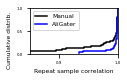

In [46]:
#Plot cumulative density plot using the previous both functions
r_list_man = get_repeat_sample_corr(nat_repeats_only_df)
r_list_Ali = get_repeat_sample_corr(my_repeat_selected_pheno_df)
make_cummulative_dens_plots(r_list_man, r_list_Ali, save_to_file='/home/antton/TFM/utils/repeat_donor_correlation')

We can see that AliGater appears to be more consistent with it's gating overall.

## Per-phenotype consistency between replicates
To further study the repeat analysis data, all 56 samples were plotted in a separate scatterplot for each phentype where each axis corresponed to a measurement. The data points are expected to be close to the diagonal overall.

In [51]:
def get_values_4_scatterplot(repeat_selected_pheno_df, phenotype):
    #Function that extracts the values corresponding to a specific phenotype
    
    v1_scatterplot = list() #x_values
    v2_scatterplot = list() #y_values

    for sample_name in repeat_selected_pheno_df.index.unique():
        sample_df = repeat_selected_pheno_df.loc[sample_name]

        #Rename index so that names are different
        new_index_name_list = list()
        for index, repeat in enumerate(sample_df.index.tolist()): #Iterate through sub-dataframe of same sample
            new_index_name_list.append(repeat+'_'+str(index))
        sample_df.set_axis(new_index_name_list,axis='rows',inplace=True)

        #Values used to draw scatterplot
        val_1 = sample_df.loc[new_index_name_list[-2]][phenotype]
        val_2 = sample_df.loc[new_index_name_list[-1]][phenotype]
        v1_scatterplot.append(val_1)
        v2_scatterplot.append(val_2)


    return v1_scatterplot, v2_scatterplot

In [52]:
def plot_scatterplot(x, y, pheno_name, save_to_file=None):
    
    plt.clf()
    plt.rcParams["figure.figsize"] =  [1.66, 1.0]
    #Spearman correlation
    spearmanR, p_value = spearmanr(x,y)
    
    # Plot
    plt.scatter(x, y, alpha=0.5)
    plt.title(pheno_name+'\nSpearmanR= '+str(round(spearmanR,2))+' (p='+'{:.2e}'.format(p_value)+')' )
    plt.xlabel('Dup. 1', fontsize=6)
    plt.ylabel('Dup. 2', fontsize=6)
    
    #Identity line
    plt.plot( [0,max(x)],[0,max(y)] )
    
    if save_to_file is not None:
        plt.savefig(save_to_file, dpi=300, bbox_inches='tight')
    else:
        plt.show()
        

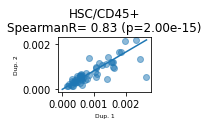

In [55]:
#Save my correlation plots to file in utils folder
for phenotype in my_repeat_selected_pheno_df.columns.tolist():
    vec1, vec2 = get_values_4_scatterplot(my_repeat_selected_pheno_df, phenotype)
    plot_scatterplot(vec1, vec2, phenotype, save_to_file='/home/antton/TFM/utils/AliGater'+phenotype.replace('/','-'))

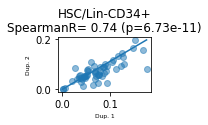

In [56]:
#Plot Natsumi's correlation plots
for phenotype in nat_repeats_only_df.columns.tolist():
    vec1, vec2 = get_values_4_scatterplot(nat_repeats_only_df, phenotype)
    plot_scatterplot(vec1, vec2, phenotype,  save_to_file='/home/antton/TFM/utils/Manual'+phenotype.replace('/','-'))